### Import module

In [7]:
import numpy as np
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import time


In [8]:
# Example usage of PushUpCounter function
model = YOLO('yolo11n-pose.pt')

In [9]:
class PushUpCounter:
    def __init__(self, down_threshold=80, up_threshold=100, buffer_size=30, min_confidence=0.5, confidence_threshold=0.50, time_between_counts=1.0):
        self.down_threshold = down_threshold
        self.up_threshold = up_threshold
        self.buffer_size = buffer_size
        self.min_confidence = min_confidence
        self.confidence_threshold = confidence_threshold
        self.time_between_counts = time_between_counts
        
        # State variables
        self.current_state = "unknown"
        self.selected_arm = None
        self.angle_buffer = []
        self.last_time_counted = 0
        self.count = 0
    
    def calculate_angle(self, shoulder_point, elbow_point, wrist_point):
        shoulder = np.array(shoulder_point)
        elbow = np.array(elbow_point)
        wrist = np.array(wrist_point)
        
        elbow_to_shoulder_vector = shoulder - elbow
        elbow_to_wrist_vector = wrist - elbow

        cos_angle = np.dot(elbow_to_shoulder_vector, elbow_to_wrist_vector) / (np.linalg.norm(elbow_to_shoulder_vector) * np.linalg.norm(elbow_to_wrist_vector))
        cos_angle = np.clip(cos_angle, -1.0, 1.0)
        angle = np.arccos(cos_angle)
        angle_degrees = np.degrees(angle)
        return angle_degrees
        
    def process_frame(self, results):
       
        if not results or not results[0].keypoints:
            return {
                'count': self.count,
                'state': self.current_state,
                'angle': None,
                'arm': 'NONE',
                'message': 'No keypoints detected'
            }
        is_confident = False
        confidences = results[0].keypoints.conf[0]
        keypoints = results[0].keypoints.xy[0]
        
        left_angle_hand = float('inf')
        right_angle_hand = float('inf')
        confidence_left_average = 0
        confidence_right_average = 0
        
        # Calculate left arm angle - only if all keypoints have confidence >= 60%
        if len(keypoints) > 9:
            left_shoulder_conf = confidences[5]
            left_elbow_conf = confidences[7]
            left_wrist_conf = confidences[9]
            
            # Check if ALL arm keypoints have confidence >= 60%
            if (left_shoulder_conf >= self.confidence_threshold and left_elbow_conf >= self.confidence_threshold and left_wrist_conf >= self.confidence_threshold):
                left_elbow_point = keypoints[7]
                left_shoulder_point = keypoints[5]
                left_wrist_point = keypoints[9]
                is_confident = True
                confidence_left_average = (left_shoulder_conf + left_elbow_conf + left_wrist_conf) / 3
                print(f'Left Shoulder: {left_shoulder_conf:.2f}, Elbow: {left_elbow_conf:.2f}, Wrist: {left_wrist_conf:.2f}')
                left_angle_hand = self.calculate_angle(left_shoulder_point, left_elbow_point, left_wrist_point)
            else:
                print(f'Left arm skipped - Low confidence: Shoulder: {left_shoulder_conf:.2f}, Elbow: {left_elbow_conf:.2f}, Wrist: {left_wrist_conf:.2f}')
        
        # Calculate right arm angle - only if all keypoints have confidence >= 60%
        if len(keypoints) > 10:
            right_shoulder_conf = confidences[6]
            right_elbow_conf = confidences[8]
            right_wrist_conf = confidences[10]
            # Check if ALL arm keypoints have confidence >= confidence_threshold
            if (right_shoulder_conf >= self.confidence_threshold and right_elbow_conf >= self.confidence_threshold and right_wrist_conf >= self.confidence_threshold):
                right_elbow_point = keypoints[8]
                right_shoulder_point = keypoints[6]
                right_wrist_point = keypoints[10]
                is_confident = True
                confidence_right_average = (right_shoulder_conf + right_elbow_conf + right_wrist_conf) / 3
                print(f'Right Shoulder: {right_shoulder_conf:.2f}, Elbow: {right_elbow_conf:.2f}, Wrist: {right_wrist_conf:.2f}')
                right_angle_hand = self.calculate_angle(right_shoulder_point, right_elbow_point, right_wrist_point)
            else:
                print(f'Right arm skipped - Low confidence: Shoulder: {right_shoulder_conf:.2f}, Elbow: {right_elbow_conf:.2f}, Wrist: {right_wrist_conf:.2f}')
        
        # Arm selection logic - choose once and stick with it
        if self.selected_arm is None:
            if (confidence_left_average > confidence_right_average and 
                left_angle_hand != float('inf')):
                self.selected_arm = "left"
            elif right_angle_hand != float('inf'):
                self.selected_arm = "right"
        
        # Get current angle from selected arm
        if self.selected_arm == "left" and left_angle_hand != float('inf'):
            raw_angle = left_angle_hand
            arm_label = "LEFT"
        elif self.selected_arm == "right" and right_angle_hand != float('inf'):
            raw_angle = right_angle_hand
            arm_label = "RIGHT"
        else:
            return {
                'count': self.count,
                'state': self.current_state,
                'angle': None,
                'arm': 'NONE',
                'message': 'Selected arm not available'
            }
        
        # Apply angle smoothing
        self.angle_buffer.append(raw_angle)
        if len(self.angle_buffer) > self.buffer_size:
            self.angle_buffer.pop(0)
        
        # Use smoothed angle (average of recent frames)
        smoothed_angle = sum(self.angle_buffer) / len(self.angle_buffer)
        
        # State machine with buffer zone (hysteresis)
        previous_state = self.current_state
        
        if is_confident:
            if smoothed_angle < self.down_threshold:
                # Clearly in down position
                if self.current_state == "up" and (time.time() - self.last_time_counted) > self.time_between_counts:
                    # Transition from up to down - complete push-up
                    self.count += 1
                    self.last_time_counted = time.time()
                self.current_state = "down"
            elif smoothed_angle > self.up_threshold:
                # Clearly in up position
                self.current_state = "up"
            # If angle is between thresholds, maintain current state (buffer zone)
        
        return {
            'count': self.count,
            'state': self.current_state,
            'previous_state': previous_state,
            'raw_angle': raw_angle,
            'smoothed_angle': smoothed_angle,
            'arm': arm_label,
            'is_confidence': is_confident
        }
    
    def reset(self):
        """Reset counter state"""
        self.current_state = "unknown"
        self.selected_arm = None
        self.angle_buffer = []
        self.count = 0

### Test Image

Left Shoulder: 0.97, Elbow: 0.64, Wrist: 0.51
Right arm skipped - Low confidence: Shoulder: 0.77, Elbow: 0.31, Wrist: 0.38
{'count': 0, 'state': 'down', 'previous_state': 'unknown', 'raw_angle': np.float32(41.012505), 'smoothed_angle': np.float32(41.012505), 'arm': 'LEFT', 'is_confidence': True}


/var/folders/7y/tb8vlfv937523rgqdlf0zjy40000gn/T/ipykernel_26073/177626127.py:18: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  shoulder = np.array(shoulder_point)
/var/folders/7y/tb8vlfv937523rgqdlf0zjy40000gn/T/ipykernel_26073/177626127.py:19: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  elbow = np.array(elbow_point)
/var/folders/7y/tb8vlfv937523rgqdlf0zjy40000gn/T/ipykernel_26073/177626127.py:20: DeprecationWarning: __array__ implementation doesn't accept a copy keyword

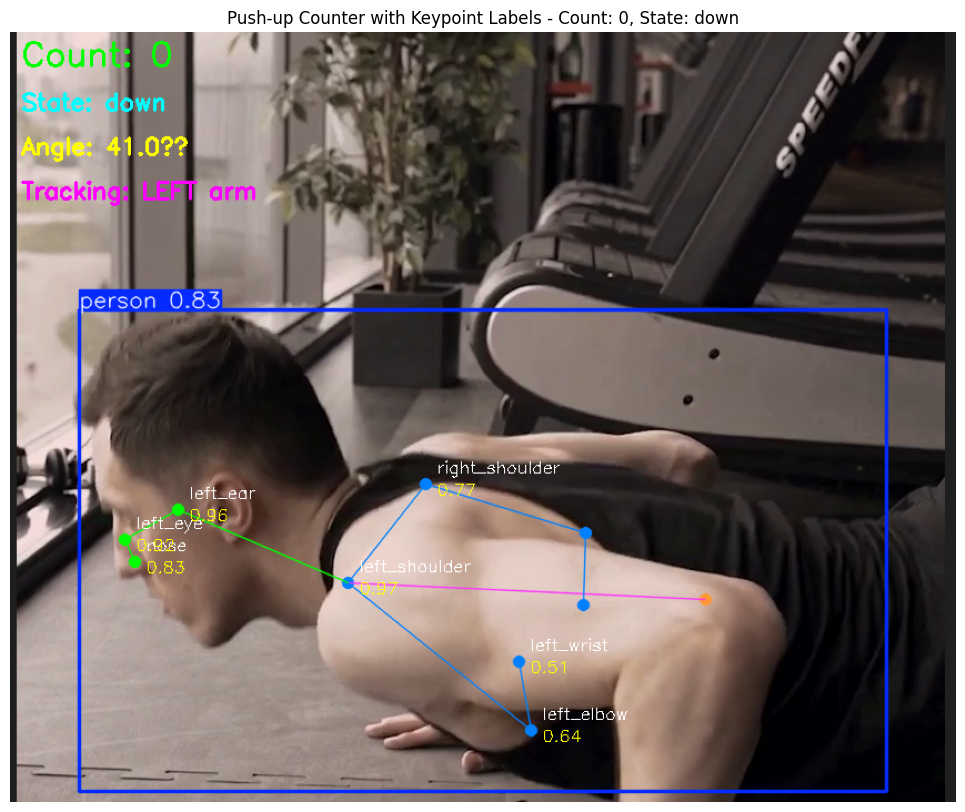

In [10]:
# Initialize the push-up counter
pushup_counter = PushUpCounter(
    down_threshold=80,    # < 80 degrees = down state
    up_threshold=100,     # > 100 degrees = up state
    buffer_size=3,        # Average of 3 frames for smoothing
    min_confidence=0.5,   # Minimum keypoint confidence
)

# Predict on current frame
results = model.predict(source='0.png', show=False, verbose=False)

# Process frame with our function
result_info = pushup_counter.process_frame(results)
print(result_info)

# Get the annotated image
annotated_image = results[0].plot()

# Add custom keypoint labels
if results[0].keypoints is not None:
    keypoints = results[0].keypoints.xy[0]
    confidences = results[0].keypoints.conf[0]
    
    # Define keypoint names for YOLO pose (COCO format)
    keypoint_names = [
        "nose", "left_eye", "right_eye", "left_ear", "right_ear",
        "left_shoulder", "right_shoulder", "left_elbow", "right_elbow",
        "left_wrist", "right_wrist", "left_hip", "right_hip",
        "left_knee", "right_knee", "left_ankle", "right_ankle"
    ]
    
    # Add labels for keypoints with high confidence
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    thickness = 1
    
    for i, (keypoint, confidence, name) in enumerate(zip(keypoints, confidences, keypoint_names)):
        if confidence > 0.5:  # Only show if confidence is high
            x, y = int(keypoint[0]), int(keypoint[1])
            
            # Add keypoint name near the point
            cv2.putText(annotated_image, name, (x + 10, y - 10), 
                       font, font_scale, (255, 255, 255), thickness)
            
            # Add confidence score
            cv2.putText(annotated_image, f"{confidence:.2f}", (x + 10, y + 10), 
                       font, font_scale, (0, 255, 255), thickness)

# Add push-up counter info
if 'smoothed_angle' in result_info and result_info['smoothed_angle'] is not None:
    cv2.putText(annotated_image, f"Count: {result_info['count']}", (10, 30), 
               cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    cv2.putText(annotated_image, f"State: {result_info['state']}", (10, 70), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 0), 2)
    cv2.putText(annotated_image, f"Angle: {result_info['smoothed_angle']:.1f}°", (10, 110), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 255), 2)
    cv2.putText(annotated_image, f"Tracking: {result_info['arm']} arm", (10, 150), 
               cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 0, 255), 2)

# Display the image using matplotlib
plt.figure(figsize=(15, 10))
plt.imshow(cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"Push-up Counter with Keypoint Labels - Count: {result_info['count']}, State: {result_info['state']}")
plt.show()

### Test 

In [11]:


# # Initialize the push-up counter
# pushup_counter = PushUpCounter(
#     down_threshold=80,    # < 80 degrees = down state
#     up_threshold=100,     # > 100 degrees = up state
#     buffer_size=3,        # Average of 3 frames for smoothing
#     min_confidence=0.5    # Minimum keypoint confidence
# )

# # Open video file
# cap = cv2.VideoCapture('push1.mp4')
# frame_count = 0

# while cap.isOpened():
#     ret, frame = cap.read()
#     frame_count += 1
#     if not ret:
#         break
    
#     # Predict on current frame
#     results = model.predict(source=frame, show=False, verbose=False)
    
#     # Process frame with our function
#     result_info = pushup_counter.process_frame(results)

#     # Display frame
#     if results and results[0].keypoints is not None:
#         annotated_frame = results[0].plot()
#     else:
#         annotated_frame = frame
    
#     cv2.imshow('Push-up Counter', annotated_frame)
    
#     if cv2.waitKey(1) & 0xFF == ord('q'):
#         break

# print('Total Frames Processed:', frame_count)
# cap.release()
# cv2.destroyAllWindows()
# print('Total Push-ups:', pushup_counter.count)

### Real-time Camera Push-up Counter

In [12]:
# Real-time Camera Push-up Counter
model = YOLO('yolo11n-pose.pt')

# Initialize the push-up counter
pushup_counter = PushUpCounter(
    down_threshold=80,    # < 80 degrees = down state
    up_threshold=100,     # > 100 degrees = up state
    buffer_size=3,        # Average of 3 frames for smoothing
    min_confidence=0.5    # Minimum keypoint confidence
)

# Open camera (0 is usually the default camera)
cap = cv2.VideoCapture(0)

# Set camera properties (optional)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
cap.set(cv2.CAP_PROP_FPS, 30)

print("Starting real-time push-up counter...")
print("Position yourself so your full body is visible in the frame")
print("Press 'q' to quit, 'r' to reset counter")

frame_count = 0

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame from camera")
        break
    
    frame_count += 1
    
    # Flip frame horizontally for mirror effect (more natural)
    frame = cv2.flip(frame, 1)
    
    # Predict on current frame
    results = model.predict(source=frame, show=False, verbose=False)
    
    # Process frame with our function
    result_info = pushup_counter.process_frame(results)
    
    # Create display frame
    if results and results[0].keypoints is not None:
        annotated_frame = results[0].plot()
        # Flip the annotated frame too
        annotated_frame = cv2.flip(annotated_frame, 1)
    else:
        annotated_frame = frame
    
    # Add counter information to the frame
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 1
    thickness = 2
    
    # Display push-up count
    count_text = f"Push-ups: {result_info['count']}"
    cv2.putText(annotated_frame, count_text, (10, 40), font, font_scale, (0, 255, 0), thickness)
    
    # Display current state
    if 'state' in result_info:
        state_text = f"State: {result_info['state']}"
        cv2.putText(annotated_frame, state_text, (10, 80), font, 0.7, (255, 255, 0), 2)
    if 'is_confidence' in result_info:
        confidence_text = f"Confidence: {'Yes' if result_info['is_confidence'] else 'No'}"
        cv2.putText(annotated_frame, confidence_text, (10, 100), font, 0.7, (255, 0, 0), 2)
    # Display current angle if available
    if 'raw_angle' in result_info and result_info['raw_angle'] is not None:
        angle_text = f"Raw Angle: {result_info['raw_angle']:.1f}°"
        cv2.putText(annotated_frame, angle_text, (10, 120), font, 0.7, (0, 255, 255), 2)
        
        # Display which arm is being tracked
        if 'arm' in result_info:
            arm_text = f"Tracking: {result_info['arm']} arm"
            cv2.putText(annotated_frame, arm_text, (10, 160), font, 0.7, (255, 0, 255), 2)
    
    # Display instructions
    cv2.putText(annotated_frame, "Press 'q' to quit, 'r' to reset", (10, annotated_frame.shape[0] - 20), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    
    # Show the frame
    cv2.imshow('Real-time Push-up Counter', annotated_frame)
    
    # Handle key presses
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break
    elif key == ord('r'):
        # Reset counter
        pushup_counter.reset()
        print(f"Counter reset at frame {frame_count}")
    
    # Print push-up completion (optional - can be commented out to reduce console output)
    if 'smoothed_angle' in result_info and result_info['smoothed_angle'] is not None:
        if result_info['state'] == 'down' and result_info.get('previous_state') == 'up':
            print(f"Push-up #{result_info['count']} completed! (angle: {result_info['smoothed_angle']:.1f}°)")

print(f"Session ended. Total frames processed: {frame_count}")
print(f"Total push-ups completed: {pushup_counter.count}")

# Release resources
cap.release()
cv2.destroyAllWindows()

Starting real-time push-up counter...
Position yourself so your full body is visible in the frame
Press 'q' to quit, 'r' to reset counter
Left arm skipped - Low confidence: Shoulder: 0.80, Elbow: 0.09, Wrist: 0.18
Right arm skipped - Low confidence: Shoulder: 0.73, Elbow: 0.06, Wrist: 0.16
Left arm skipped - Low confidence: Shoulder: 0.81, Elbow: 0.08, Wrist: 0.17
Right arm skipped - Low confidence: Shoulder: 0.72, Elbow: 0.05, Wrist: 0.13
Left arm skipped - Low confidence: Shoulder: 0.82, Elbow: 0.10, Wrist: 0.20
Right arm skipped - Low confidence: Shoulder: 0.70, Elbow: 0.04, Wrist: 0.13
Left arm skipped - Low confidence: Shoulder: 0.83, Elbow: 0.11, Wrist: 0.22
Right arm skipped - Low confidence: Shoulder: 0.70, Elbow: 0.05, Wrist: 0.15
Left arm skipped - Low confidence: Shoulder: 0.83, Elbow: 0.13, Wrist: 0.26
Right arm skipped - Low confidence: Shoulder: 0.67, Elbow: 0.04, Wrist: 0.15
Left arm skipped - Low confidence: Shoulder: 0.83, Elbow: 0.16, Wrist: 0.43
Right arm skipped - L

/var/folders/7y/tb8vlfv937523rgqdlf0zjy40000gn/T/ipykernel_26073/177626127.py:18: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  shoulder = np.array(shoulder_point)
/var/folders/7y/tb8vlfv937523rgqdlf0zjy40000gn/T/ipykernel_26073/177626127.py:19: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  elbow = np.array(elbow_point)
/var/folders/7y/tb8vlfv937523rgqdlf0zjy40000gn/T/ipykernel_26073/177626127.py:20: DeprecationWarning: __array__ implementation doesn't accept a copy keyword

Left arm skipped - Low confidence: Shoulder: 0.97, Elbow: 0.68, Wrist: 0.48
Right Shoulder: 0.97, Elbow: 0.72, Wrist: 0.53
Left Shoulder: 0.99, Elbow: 0.90, Wrist: 0.79
Right Shoulder: 0.99, Elbow: 0.89, Wrist: 0.79
Left Shoulder: 0.99, Elbow: 0.87, Wrist: 0.66
Right Shoulder: 0.99, Elbow: 0.86, Wrist: 0.65
Left Shoulder: 0.99, Elbow: 0.93, Wrist: 0.74
Right Shoulder: 0.98, Elbow: 0.85, Wrist: 0.61
Left Shoulder: 0.99, Elbow: 0.92, Wrist: 0.67
Right arm skipped - Low confidence: Shoulder: 0.97, Elbow: 0.67, Wrist: 0.38
Left Shoulder: 0.99, Elbow: 0.90, Wrist: 0.64
Right arm skipped - Low confidence: Shoulder: 0.98, Elbow: 0.74, Wrist: 0.44
Left Shoulder: 0.99, Elbow: 0.84, Wrist: 0.58
Right Shoulder: 0.99, Elbow: 0.83, Wrist: 0.58
Left Shoulder: 0.99, Elbow: 0.92, Wrist: 0.69
Right Shoulder: 0.98, Elbow: 0.81, Wrist: 0.51
Left arm skipped - Low confidence: Shoulder: 0.98, Elbow: 0.57, Wrist: 0.43
Right Shoulder: 0.99, Elbow: 0.82, Wrist: 0.62
Left arm skipped - Low confidence: Shoulder

KeyboardInterrupt: 

### Optimized Real-time Camera (Skip Frames)

In [ ]:
# Optimized Real-time Camera Push-up Counter with Frame Skipping
import time

model = YOLO('yolo11n-pose.pt')

# Initialize the push-up counter
pushup_counter = PushUpCounter(
    down_threshold=80,    # < 80 degrees = down state
    up_threshold=100,     # > 100 degrees = up state
    buffer_size=3,        # Average of 3 frames for smoothing
    min_confidence=0.5,   # Minimum keypoint confidence
    confidence_threshold=0.6  # 60% individual keypoint threshold
)

# Open camera (0 is usually the default camera)
cap = cv2.VideoCapture(0)

# Set camera properties for better performance
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)   # Lower resolution for speed
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
cap.set(cv2.CAP_PROP_FPS, 30)
cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)      # Reduce buffer to prevent lag

print("Starting optimized real-time push-up counter...")
print("Position yourself so your full body is visible in the frame")
print("Press 'q' to quit, 'r' to reset counter")

frame_count = 0
processed_frames = 0
skip_frames = 2  # Process every 3rd frame (skip 2, process 1)
last_result_info = None
fps_counter = 0
fps_start_time = time.time()

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Failed to grab frame from camera")
        break
    
    frame_count += 1
    
    # Flip frame horizontally for mirror effect (more natural)
    frame = cv2.flip(frame, 1)
    
    # Skip frames for performance - only process every 3rd frame
    if frame_count % (skip_frames + 1) != 0:
        # Display previous result on skipped frames
        annotated_frame = frame.copy()
        
        # Add cached information if available
        if last_result_info is not None:
            font = cv2.FONT_HERSHEY_SIMPLEX
            
            # Display push-up count
            count_text = f"Push-ups: {last_result_info['count']}"
            cv2.putText(annotated_frame, count_text, (10, 40), font, 1, (0, 255, 0), 2)
            
            # Display current state
            state_text = f"State: {last_result_info['state']}"
            cv2.putText(annotated_frame, state_text, (10, 80), font, 0.7, (255, 255, 0), 2)
            
            # Show frame skip indicator
            cv2.putText(annotated_frame, "SKIPPED FRAME", (10, 120), font, 0.6, (255, 0, 0), 2)
    else:
        # Process this frame
        processed_frames += 1
        
        # Predict on current frame
        results = model.predict(source=frame, show=False, verbose=False)
        
        # Process frame with our function
        result_info = pushup_counter.process_frame(results)
        last_result_info = result_info  # Cache for skipped frames
        
        # Create display frame
        if results and results[0].keypoints is not None:
            annotated_frame = results[0].plot()
            # Flip the annotated frame too
            annotated_frame = cv2.flip(annotated_frame, 1)
        else:
            annotated_frame = frame
        
        # Add counter information to the frame
        font = cv2.FONT_HERSHEY_SIMPLEX
        
        # Display push-up count
        count_text = f"Push-ups: {result_info['count']}"
        cv2.putText(annotated_frame, count_text, (10, 40), font, 1, (0, 255, 0), 2)
        
        # Display current state
        if 'state' in result_info:
            state_text = f"State: {result_info['state']}"
            cv2.putText(annotated_frame, state_text, (10, 80), font, 0.7, (255, 255, 0), 2)
        
        # Display confidence status
        if 'is_confidence' in result_info:
            confidence_text = f"Confidence: {'Yes' if result_info['is_confidence'] else 'No'}"
            color = (0, 255, 0) if result_info['is_confidence'] else (0, 0, 255)
            cv2.putText(annotated_frame, confidence_text, (10, 120), font, 0.7, color, 2)
        
        # Display current angle if available
        if 'raw_angle' in result_info and result_info['raw_angle'] is not None:
            angle_text = f"Angle: {result_info['raw_angle']:.1f}°"
            cv2.putText(annotated_frame, angle_text, (10, 160), font, 0.7, (0, 255, 255), 2)
            
            # Display which arm is being tracked
            if 'arm' in result_info:
                arm_text = f"Tracking: {result_info['arm']} arm"
                cv2.putText(annotated_frame, arm_text, (10, 200), font, 0.7, (255, 0, 255), 2)
        
        # Show processing indicator
        cv2.putText(annotated_frame, "PROCESSED", (10, 240), font, 0.6, (0, 255, 0), 2)
        
        # Print push-up completion
        if 'smoothed_angle' in result_info and result_info['smoothed_angle'] is not None:
            if result_info['state'] == 'down' and result_info.get('previous_state') == 'up':
                print(f"Push-up #{result_info['count']} completed! (angle: {result_info['smoothed_angle']:.1f}°)")
    
    # Calculate and display FPS
    fps_counter += 1
    if fps_counter % 30 == 0:  # Update FPS every 30 frames
        fps = 30 / (time.time() - fps_start_time)
        fps_start_time = time.time()
        print(f"FPS: {fps:.1f}, Processed: {processed_frames}/{frame_count} frames ({processed_frames/frame_count*100:.1f}%)")
    
    # Add FPS and processing info to display
    fps_text = f"FPS: {30/(time.time() - fps_start_time + 0.001):.1f}"
    cv2.putText(annotated_frame, fps_text, (10, annotated_frame.shape[0] - 60), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    
    processing_text = f"Processing: {processed_frames}/{frame_count} ({processed_frames/frame_count*100:.0f}%)"
    cv2.putText(annotated_frame, processing_text, (10, annotated_frame.shape[0] - 40), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    
    # Display instructions
    cv2.putText(annotated_frame, "Press 'q' to quit, 'r' to reset", (10, annotated_frame.shape[0] - 20), 
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    
    # Show the frame
    cv2.imshow('Optimized Push-up Counter', annotated_frame)
    
    # Handle key presses
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        break
    elif key == ord('r'):
        # Reset counter
        pushup_counter.reset()
        last_result_info = None
        print(f"Counter reset at frame {frame_count}")
    elif key == ord('s'):
        # Toggle skip rate
        skip_frames = 0 if skip_frames > 0 else 2
        print(f"Frame skipping: {'ON' if skip_frames > 0 else 'OFF'}")

print(f"Session ended.")
print(f"Total frames captured: {frame_count}")
print(f"Frames processed: {processed_frames} ({processed_frames/frame_count*100:.1f}%)")
print(f"Total push-ups completed: {pushup_counter.count}")

# Release resources
cap.release()
cv2.destroyAllWindows()

### Voice-Enabled Real-time Camera (with Text-to-Speech)

In [ ]:
# Install text-to-speech library (run this first)
# !pip install pyttsx3

In [ ]:
# # Voice-Enabled Real-time Camera Push-up Counter
# import time
# import pyttsx3  # Text-to-speech library
# import threading  # For non-blocking speech

# # Initialize text-to-speech engine
# def init_tts():
#     try:
#         engine = pyttsx3.init()
#         # Configure voice settings
#         voices = engine.getProperty('voices')
#         if voices:
#             engine.setProperty('voice', voices[0].id)  # Use first available voice
#         engine.setProperty('rate', 150)  # Speaking rate
#         engine.setProperty('volume', 0.8)  # Volume level (0.0 to 1.0)
#         return engine
#     except Exception as e:
#         print(f"Warning: Text-to-speech not available: {e}")
#         return None

# def speak_async(engine, text):
#     """Speak text in a separate thread to avoid blocking"""
#     if engine:
#         def speak():
#             try:
#                 engine.say(text)
#                 engine.runAndWait()
#             except:
#                 pass
#         thread = threading.Thread(target=speak, daemon=True)
#         thread.start()

# # Initialize TTS engine
# tts_engine = init_tts()

# model = YOLO('yolo11n-pose.pt')

# # Initialize the push-up counter
# pushup_counter = PushUpCounter(
#     down_threshold=80,    # < 80 degrees = down state
#     up_threshold=100,     # > 100 degrees = up state
#     buffer_size=3,        # Average of 3 frames for smoothing
#     min_confidence=0.5,   # Minimum keypoint confidence
#     confidence_threshold=0.6  # 60% individual keypoint threshold
# )

# # Open camera (0 is usually the default camera)
# cap = cv2.VideoCapture(0)

# # Set camera properties for better performance
# cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
# cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
# cap.set(cv2.CAP_PROP_FPS, 30)
# cap.set(cv2.CAP_PROP_BUFFERSIZE, 1)

# print("Starting voice-enabled push-up counter...")
# if tts_engine:
#     speak_async(tts_engine, "Push-up counter ready. Position yourself in the frame.")
#     print("Text-to-speech enabled - you'll hear voice announcements!")
# else:
#     print("Text-to-speech not available - using visual display only")

# print("Position yourself so your full body is visible in the frame")
# print("Press 'q' to quit, 'r' to reset counter, 's' to toggle frame skipping")

# frame_count = 0
# processed_frames = 0
# skip_frames = 2  # Process every 3rd frame (skip 2, process 1)
# last_result_info = None
# fps_counter = 0
# fps_start_time = time.time()
# last_spoken_count = 0  # Track last announced count
# confidence_warning_spoken = False  # Prevent repeated confidence warnings
# startup_announced = False

# while cap.isOpened():
#     ret, frame = cap.read()
#     if not ret:
#         print("Failed to grab frame from camera")
#         break
    
#     frame_count += 1
    
#     # Flip frame horizontally for mirror effect (more natural)
#     frame = cv2.flip(frame, 1)
    
#     # Skip frames for performance - only process every 3rd frame
#     if frame_count % (skip_frames + 1) != 0:
#         # Display previous result on skipped frames
#         annotated_frame = frame.copy()
        
#         # Add cached information if available
#         if last_result_info is not None:
#             font = cv2.FONT_HERSHEY_SIMPLEX
            
#             # Display push-up count
#             count_text = f"Push-ups: {last_result_info['count']}"
#             cv2.putText(annotated_frame, count_text, (10, 40), font, 1, (0, 255, 0), 2)
            
#             # Display current state
#             state_text = f"State: {last_result_info['state']}"
#             cv2.putText(annotated_frame, state_text, (10, 80), font, 0.7, (255, 255, 0), 2)
            
#             # Show frame skip indicator
#             cv2.putText(annotated_frame, "SKIPPED FRAME", (10, 120), font, 0.6, (255, 0, 0), 2)
#     else:
#         # Process this frame
#         processed_frames += 1
        
#         # Predict on current frame
#         results = model.predict(source=frame, show=False, verbose=False)
        
#         # Process frame with our function
#         result_info = pushup_counter.process_frame(results)
#         last_result_info = result_info  # Cache for skipped frames
        
#         # Voice announcements
#         if tts_engine:
#             # Announce push-up completion
#             if ('count' in result_info and result_info['count'] > last_spoken_count and 
#                 result_info['count'] > 0):
#                 count_msg = f"Push-up {result_info['count']}"
#                 speak_async(tts_engine, count_msg)
#                 last_spoken_count = result_info['count']
#                 print(f"🔊 Announced: {count_msg}")
            
#             # Announce when tracking starts (first time confidence is good)
#             if (not startup_announced and 'is_confidence' in result_info and 
#                 result_info['is_confidence'] and 'arm' in result_info):
#                 startup_msg = f"Tracking {result_info['arm'].lower()} arm. Begin your workout."
#                 speak_async(tts_engine, startup_msg)
#                 startup_announced = True
#                 confidence_warning_spoken = False
#                 print(f"🔊 Announced: {startup_msg}")
            
#             # Warn about low confidence (but not too frequently)
#             elif ('is_confidence' in result_info and not result_info['is_confidence'] and 
#                   not confidence_warning_spoken and startup_announced):
#                 speak_async(tts_engine, "Low confidence. Adjust your position.")
#                 confidence_warning_spoken = True
#                 print("🔊 Announced: Low confidence warning")
            
#             # Reset confidence warning when confidence returns
#             elif ('is_confidence' in result_info and result_info['is_confidence'] and 
#                   confidence_warning_spoken):
#                 confidence_warning_spoken = False
        
#         # Create display frame
#         if results and results[0].keypoints is not None:
#             annotated_frame = results[0].plot()
#             # Flip the annotated frame too
#             annotated_frame = cv2.flip(annotated_frame, 1)
#         else:
#             annotated_frame = frame
        
#         # Add counter information to the frame
#         font = cv2.FONT_HERSHEY_SIMPLEX
        
#         # Display push-up count (larger and more prominent)
#         count_text = f"Push-ups: {result_info['count']}"
#         cv2.putText(annotated_frame, count_text, (10, 50), font, 1.5, (0, 255, 0), 3)
        
#         # Display current state
#         if 'state' in result_info:
#             state_text = f"State: {result_info['state']}"
#             cv2.putText(annotated_frame, state_text, (10, 100), font, 0.8, (255, 255, 0), 2)
        
#         # Display confidence status
#         if 'is_confidence' in result_info:
#             confidence_text = f"Confidence: {'Good' if result_info['is_confidence'] else 'Low'}"
#             color = (0, 255, 0) if result_info['is_confidence'] else (0, 0, 255)
#             cv2.putText(annotated_frame, confidence_text, (10, 140), font, 0.7, color, 2)
        
#         # Display current angle if available
#         if 'raw_angle' in result_info and result_info['raw_angle'] is not None:
#             angle_text = f"Angle: {result_info['raw_angle']:.1f}°"
#             cv2.putText(annotated_frame, angle_text, (10, 180), font, 0.7, (0, 255, 255), 2)
            
#             # Display which arm is being tracked
#             if 'arm' in result_info:
#                 arm_text = f"Tracking: {result_info['arm']} arm"
#                 cv2.putText(annotated_frame, arm_text, (10, 220), font, 0.7, (255, 0, 255), 2)
        
#         # Show processing indicator
#         cv2.putText(annotated_frame, "PROCESSED", (10, 260), font, 0.6, (0, 255, 0), 2)
        
#         # Voice indicator
#         if tts_engine:
#             cv2.putText(annotated_frame, "🔊 VOICE ON", (10, 300), font, 0.6, (255, 255, 255), 2)
    
#     # Calculate and display FPS
#     fps_counter += 1
#     if fps_counter % 30 == 0:  # Update FPS every 30 frames
#         fps = 30 / (time.time() - fps_start_time)
#         fps_start_time = time.time()
#         # Only print FPS occasionally to reduce console clutter
#         if fps_counter % 90 == 0:  # Every 3 seconds
#             print(f"FPS: {fps:.1f}, Processed: {processed_frames}/{frame_count} frames")
    
#     # Add FPS and processing info to display
#     fps_text = f"FPS: {30/(time.time() - fps_start_time + 0.001):.1f}"
#     cv2.putText(annotated_frame, fps_text, (10, annotated_frame.shape[0] - 60), 
#                 cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    
#     processing_text = f"Processing: {processed_frames}/{frame_count} ({processed_frames/frame_count*100:.0f}%)"
#     cv2.putText(annotated_frame, processing_text, (10, annotated_frame.shape[0] - 40), 
#                 cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    
#     # Display instructions
#     cv2.putText(annotated_frame, "Press 'q' to quit, 'r' to reset, 's' to toggle skip", 
#                 (10, annotated_frame.shape[0] - 20), 
#                 cv2.FONT_HERSHEY_SIMPLEX, 0.4, (255, 255, 255), 1)
    
#     # Show the frame
#     cv2.imshow('Voice-Enabled Push-up Counter', annotated_frame)
    
#     # Handle key presses
#     key = cv2.waitKey(1) & 0xFF
#     if key == ord('q'):
#         if tts_engine:
#             speak_async(tts_engine, f"Workout complete. Total push-ups: {pushup_counter.count}")
#         break
#     elif key == ord('r'):
#         # Reset counter
#         pushup_counter.reset()
#         last_result_info = None
#         last_spoken_count = 0
#         startup_announced = False
#         confidence_warning_spoken = False
#         if tts_engine:
#             speak_async(tts_engine, "Counter reset. Ready for new workout.")
#         print(f"Counter reset at frame {frame_count}")
#     elif key == ord('s'):
#         # Toggle skip rate
#         skip_frames = 0 if skip_frames > 0 else 2
#         skip_msg = f"Frame skipping {'disabled' if skip_frames == 0 else 'enabled'}"
#         if tts_engine:
#             speak_async(tts_engine, skip_msg)
#         print(skip_msg)

# print(f"Session ended.")
# print(f"Total frames captured: {frame_count}")
# print(f"Frames processed: {processed_frames} ({processed_frames/frame_count*100:.1f}%)")
# print(f"Total push-ups completed: {pushup_counter.count}")

# if tts_engine:
#     speak_async(tts_engine, f"Final count: {pushup_counter.count} push-ups. Great workout!")

# # Release resources
# cap.release()
# cv2.destroyAllWindows()